In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
dataPath = '../myMediapipe/trainingData/staticGestures/210318_0950'

In [3]:
!ls $dataPath

labels.csv  paper2.csv	rock.csv   scissor.csv	 static_gestures_labels.txt
paper.csv   paper3.csv	rock1.csv  scissor1.csv
paper1.csv  paper4.csv	rock2.csv  scissor2.csv


In [4]:
labelsFile = os.path.join(dataPath, "labels.csv")
labels = pd.read_csv(labelsFile,header=None)
print(labels)

         0        1  2
0    Paper   paper1  0
1     Rock     rock  1
2  Scissor  scissor  2


In [5]:
preData  = {}
for label in labels.itertuples():
    trainingFile = os.path.join(dataPath,label[2] + ".csv")
    preData[label.Index] = pd.read_csv(trainingFile,header=None)
    print("Loading file:", trainingFile, "\tNumber of Rows:" , len(preData[label.Index].index))
    print(label.Index)

Loading file: ../myMediapipe/trainingData/staticGestures/210318_0950/paper1.csv 	Number of Rows: 13930
0
Loading file: ../myMediapipe/trainingData/staticGestures/210318_0950/rock.csv 	Number of Rows: 86157
1
Loading file: ../myMediapipe/trainingData/staticGestures/210318_0950/scissor.csv 	Number of Rows: 49411
2


In [6]:
# cleaning
for key in preData.keys():
    print("Record #:", key, "\thas:",len(preData[key].index) % 21, "incomplete captures")
    preData[key].drop(preData[key].tail(len(preData[key].index) % 21).index,inplace=True)

Record #: 0 	has: 7 incomplete captures
Record #: 1 	has: 15 incomplete captures
Record #: 2 	has: 19 incomplete captures


In [7]:
# balance data
recordsPerClass = len(preData[0].index) #initial value
#Calculate smallest class
for key in preData.keys():
    if recordsPerClass > len(preData[key].index): 
        recordsPerClass=len(preData[key].index)
    #print(recordsPerClass)

#Trimming
for key in preData.keys():
    preData[key] = preData[key].head(recordsPerClass)
    print(len(preData[key].index))

13923
13923
13923


In [8]:
# Builds training and label array

In [8]:
numTrainRows, numTestRows = 0,0
numLandmaks = 21
numCols = numLandmaks*2

def countRows(dataDict):
    rowsCount=0
    for key in dataDict.keys():
        rowsCount += len(dataDict[key].index)
    return rowsCount

numRows = countRows(preData)
#numTestRows = countRows(testData)

numTransRows = int(numRows / numLandmaks)
transData = np.zeros((numTransRows,numCols),preData[1][4].dtypes)
transLabels = np.zeros((numTransRows),np.int16)

#numTestRows = int(numTestRows / numLandmaks)
#testingData = np.zeros((numTestRows,numCols),preData[1][4].dtypes)
#testingLabels = np.zeros((numTestRows),np.int16)

print("Number of Rows in total:", numTransRows)  
print(transData.shape, transData.dtype)
print(transLabels.shape, transLabels.dtype)

#print(testingData.shape, testingData.dtype)
#print(testingLabels.shape, testingLabels.dtype)


Number of Rows in total: 1989
(1989, 42) float64
(1989,) int16


In [9]:
def transposeInterleave(a, b):
    c = np.empty((a.size + b.size,), dtype=a.dtype)
    c[0::2] = a
    c[1::2] = b
    return c

def dataTransp(dataDict,processedData,processedLabels):
    j = 0
    for key in dataDict.keys():
        for i in range(0, len(dataDict[key].index), numLandmaks):  
            #print(dataDict[1].iloc[i : i + numLandmaks,3:5])
            a= np.ravel(np.asarray(dataDict[key].iloc[i : i + numLandmaks,3:4]))
            b= np.ravel(np.asarray(dataDict[key].iloc[i : i + numLandmaks,4:5]))
            #print("j:",j)
            processedData[j] = transposeInterleave(a,b)
            processedLabels[j] =labels.iloc[key,2]
            j+=1
     # retun True

dataTransp(preData,transData,transLabels) 

print(transData[-1])
print(transLabels[-1])

[ 2.015168  0.        0.       -0.281733 -2.566233  0.       -2.516072
  0.        0.        0.        0.        0.55923   3.105184  0.
  3.118885  0.        0.        0.        0.       -2.958238  3.135149
  0.       -2.987015  0.        0.        0.        0.       -0.130063
  0.991339  0.        2.811815  0.        0.        0.        0.
  0.        1.83637   0.        2.854078  0.        0.        0.      ]
2


In [11]:
# Labels to one hot

In [10]:
from keras.utils import to_categorical
print(transLabels.shape)
transLabels = to_categorical(transLabels)
print(transLabels.shape)
print(transLabels[-1])

(1989,)
(1989, 3)
[0. 0. 1.]


In [13]:
# Set apart Test Data

In [11]:
from sklearn.model_selection import train_test_split
testDataRatio = 0.2

X_train, X_test, y_train, y_test = train_test_split(transData,transLabels, test_size=testDataRatio)
print( "\tTraining records:", np.shape(X_train)[0], "\n\tTest records:", np.shape(X_test)[0])

	Training records: 1591 
	Test records: 398


In [15]:
# model definition

In [12]:
from keras import models
from keras import layers
from keras import backend as K
K.clear_session()

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(numCols,)))
model.add(layers.Dense(42, activation='relu'))
model.add(layers.Dense(len(labels.index), activation='softmax'))

In [17]:
# model compile

In [13]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [19]:
# training

In [14]:
history = model.fit(X_train,
                    y_train,
                    epochs=40,
                    #batch_size=512,
                    validation_split=0.2)

Epoch 1/40
40/40 [==============================] - 0s 8ms/step - loss: 0.5008 - accuracy: 0.8200 - val_loss: 0.2928 - val_accuracy: 0.9373
Epoch 2/40
40/40 [==============================] - 0s 2ms/step - loss: 0.2565 - accuracy: 0.9292 - val_loss: 0.1743 - val_accuracy: 0.9624
Epoch 3/40
40/40 [==============================] - 0s 2ms/step - loss: 0.1776 - accuracy: 0.9528 - val_loss: 0.1291 - val_accuracy: 0.9592
Epoch 4/40
40/40 [==============================] - 0s 2ms/step - loss: 0.1339 - accuracy: 0.9631 - val_loss: 0.1003 - val_accuracy: 0.9749
Epoch 5/40
40/40 [==============================] - 0s 2ms/step - loss: 0.1047 - accuracy: 0.9693 - val_loss: 0.0771 - val_accuracy: 0.9781
Epoch 6/40
40/40 [==============================] - 0s 2ms/step - loss: 0.0815 - accuracy: 0.9741 - val_loss: 0.0636 - val_accuracy: 0.9843
Epoch 7/40
40/40 [==============================] - 0s 2ms/step - loss: 0.0663 - accuracy: 0.9803 - val_loss: 0.0555 - val_accuracy: 0.9749
Epoch 8/40
40/40 [==

In [21]:
# Plotting the training and validation loss

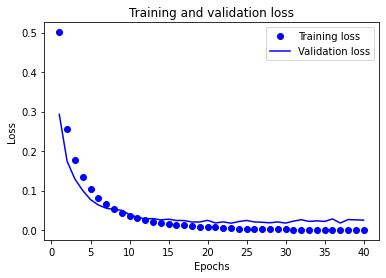

In [15]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
# Plotting the training and validation accuracy

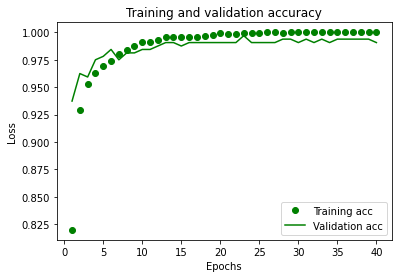

In [16]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'go', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
# Evaluate the model

In [17]:
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('\nTesting loss: {}%, acc: {}%\n'.format(round(loss*100,2),round(acc*100,2)))


Testing loss: 12.0%, acc: 98.24%



In [27]:
# TODO: Model optimization

In [18]:
# saving
model.save('gestures003.h5')

In [29]:
# To tflite

In [19]:
import tensorflow as tf
print(tf.version)

converter = tf.lite.TFLiteConverter.from_keras_model(model) 
liteModel = converter.convert()

open("gestures003.tflite", "wb").write(liteModel)

#file = open( 'gestures001.tflite' , 'wb' ) 
#file.write( liteModel )

<module 'tensorflow._api.v2.version' from '/home/nghia/venv/lib/python3.6/site-packages/tensorflow/_api/v2/version/__init__.py'>
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpwlv096iv/assets


24124